In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

# データの確認・可視化

In [45]:
#データのインポート
data = pd.read_csv('./train.csv')
data.head()

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17,0,0,-1,-1
1,2010-07-02,18,0,0,-1,-1
2,2010-07-03,20,0,0,-1,-1
3,2010-07-04,20,0,0,-1,-1
4,2010-07-05,14,0,0,-1,-1


In [46]:
data.shape

(2101, 6)

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  2101 non-null   object
 1   y         2101 non-null   int64 
 2   client    2101 non-null   int64 
 3   close     2101 non-null   int64 
 4   price_am  2101 non-null   int64 
 5   price_pm  2101 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 98.6+ KB


欠測値なし、datetime列がobject型になっているのを確認

In [48]:
#datetimeをdatetime型に変換しておく
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')

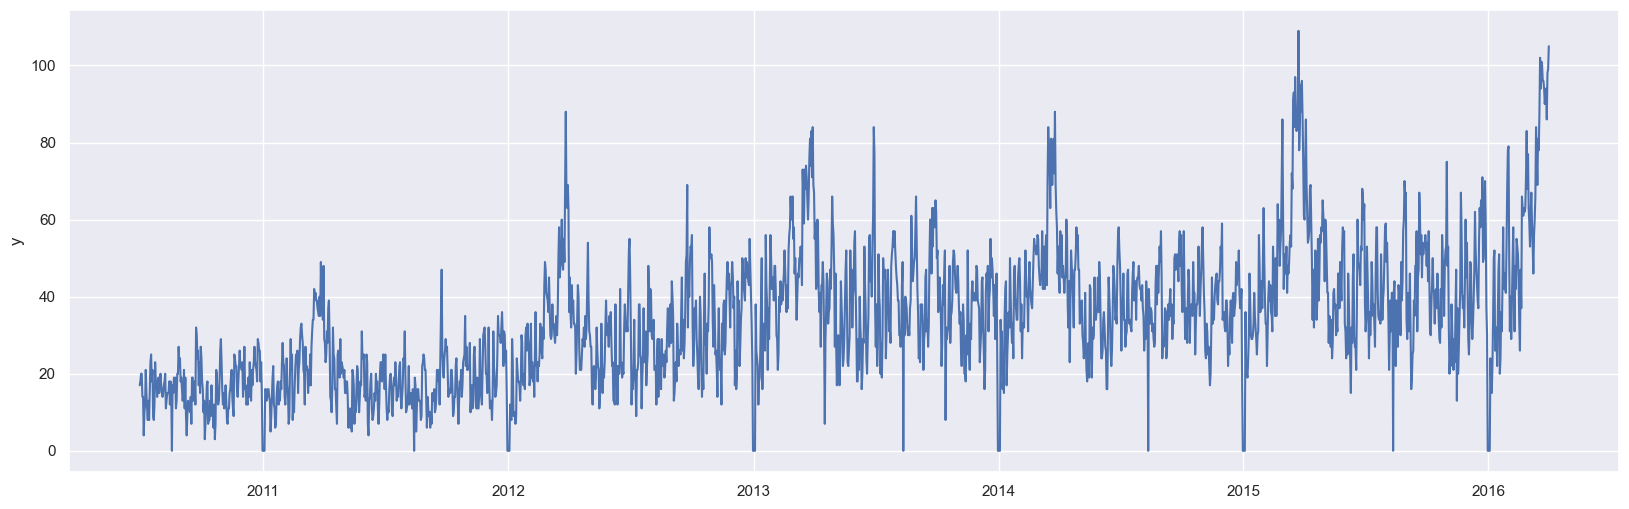

In [49]:
#各特徴量毎に時系列順にプロットしてみる
plt.figure(figsize=(20,6))
plt.plot(data['datetime'], data['y'])
plt.ylabel('y')
plt.show()

yには長期的なトレンド、季節性があることが見て取れる

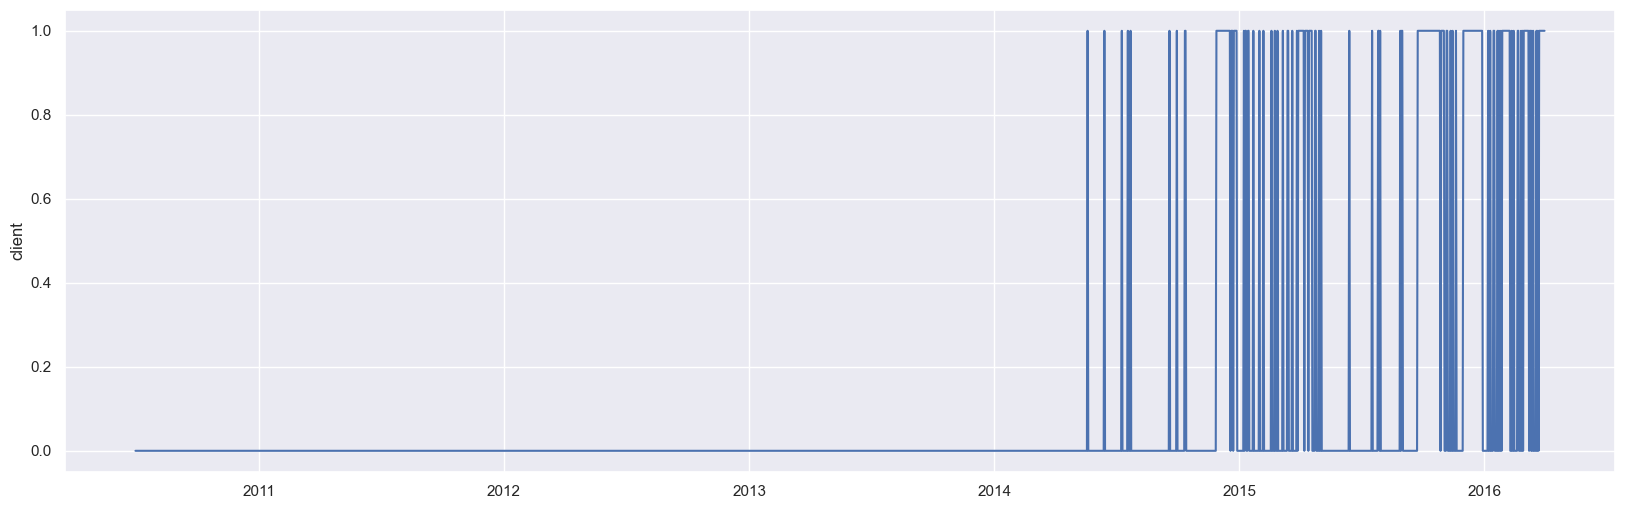

In [50]:
plt.figure(figsize=(20,6))
plt.plot(data['datetime'], data['client'])
plt.ylabel('client')
plt.show()

client(法人利用日)は2014年半ば頃から発生している

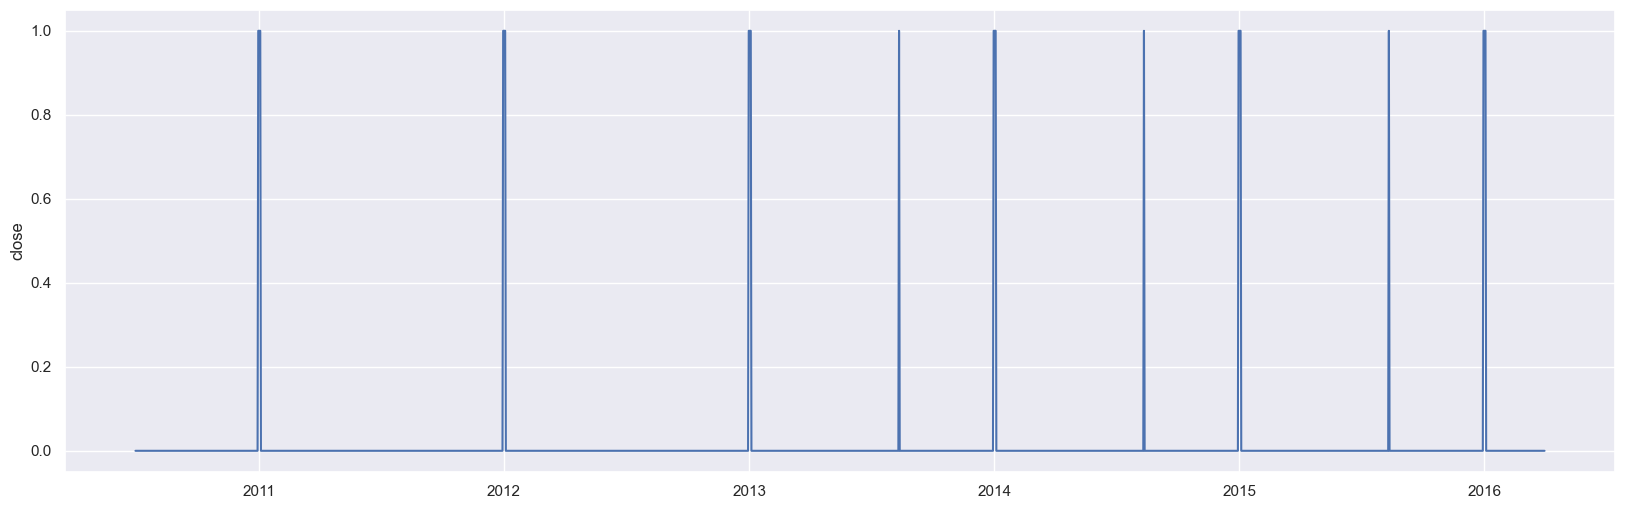

In [51]:
plt.figure(figsize=(20,6))
plt.plot(data['datetime'], data['close'])
plt.ylabel('close')
plt.show()

close（休業日）は、年末年始に数日間ある。また2013年から夏季休暇を導入したことが見て取れる

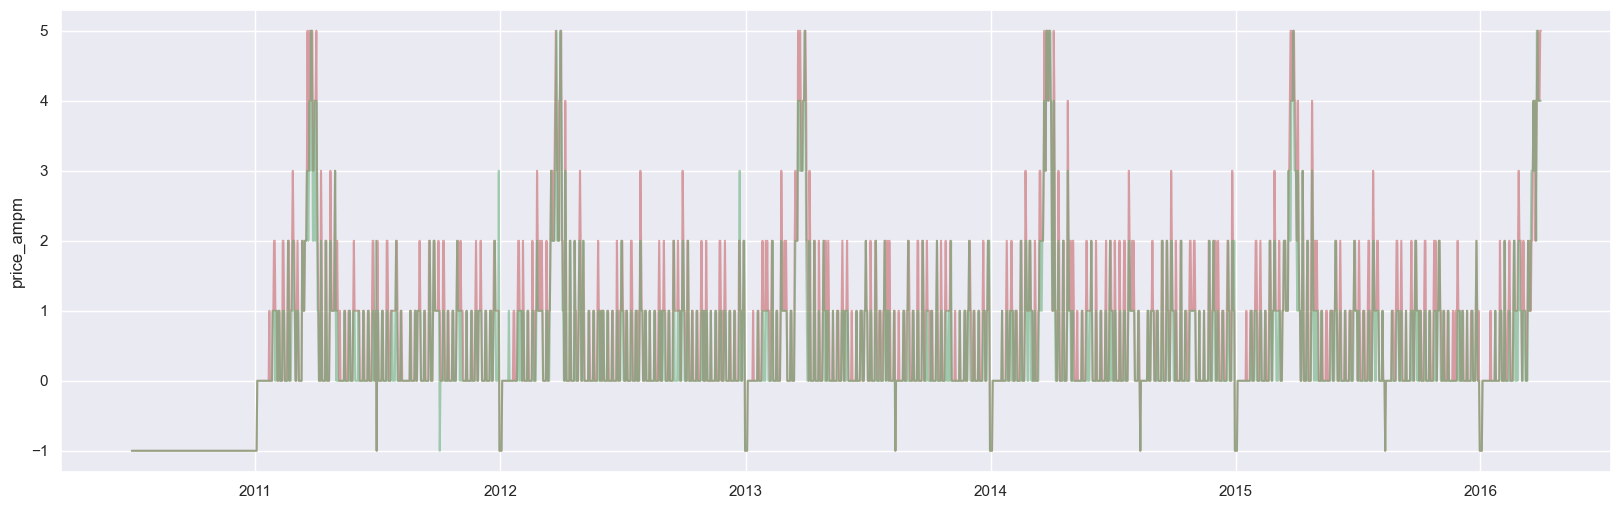

In [52]:
plt.figure(figsize=(20,6))
plt.plot(data['datetime'], data['price_am'], c='r', alpha=0.5)
plt.plot(data['datetime'], data['price_pm'], c='g', alpha=0.5)
plt.ylabel('price_ampm')
plt.show()

料金区分には一定の周期性が見て取れる。おそらく、繁忙期（3月4月）は料金を高く設定しているのだろう\
またam,pmがおおむね重なっていることから、一日の料金区分はそこまで変動しないと思われる。\
price_am、price_pmで特徴量を分ける必要はない？？

## 欠損値の解釈

price_am, price_pmには2010年において、データがすべて-1となっていることが確認できた。\
price_am, price_pmとcloseの関係を見てみると、休業日にprice_am,pmが-1になっていると思われる。\
以上のことから、2010年のprice_am,pmの値は欠損データだと判断する。\
欠測メカニズムとしては、MARが妥当。\
2010年のデータを取り除いてもデータ数が大きく減ることはないと判断し、除外することとする。

In [53]:
#データを成形
data2 = data[data["datetime"] >= "2011-04-01" ]

## 自己相関係数と偏自己相関係数を可視化する

c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


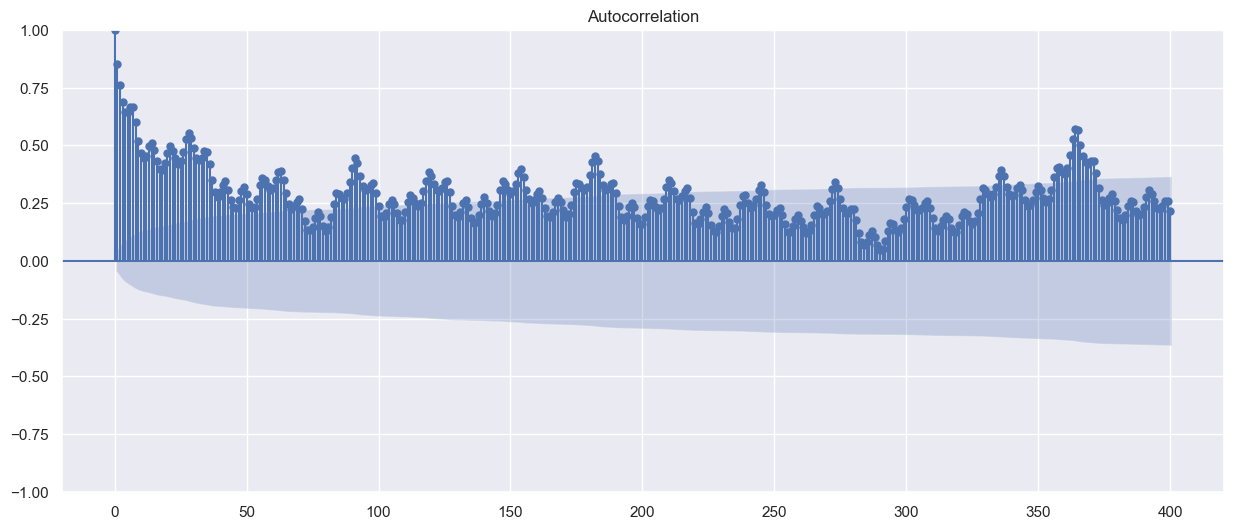

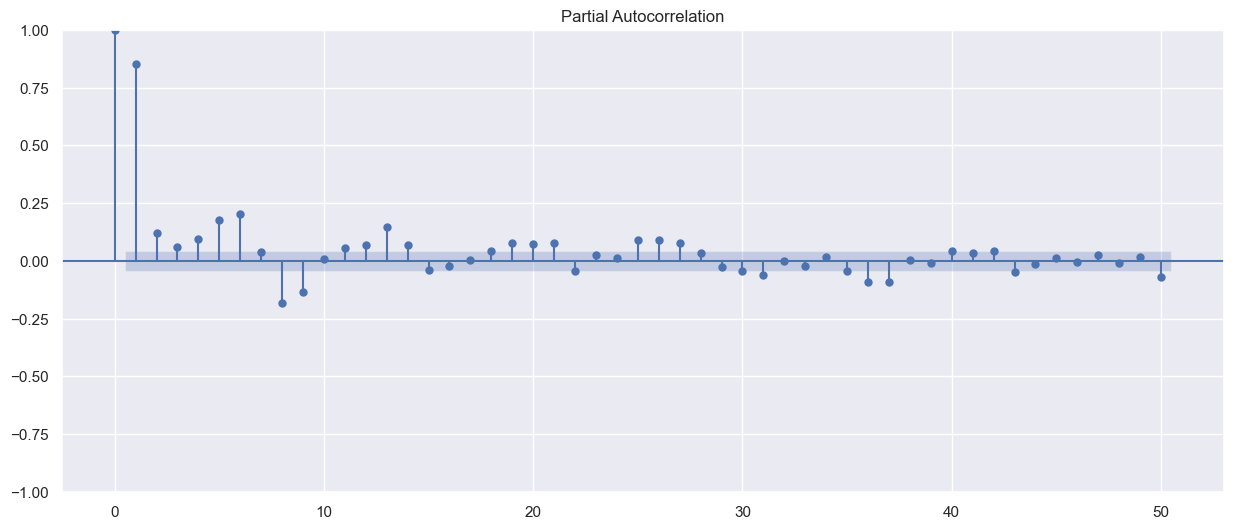

In [54]:
fig_1 = sm.graphics.tsa.plot_acf(data['y'], lags=400)
fig_2 = sm.graphics.tsa.plot_pacf(data['y'], lags=50)

## 波状分解してみる

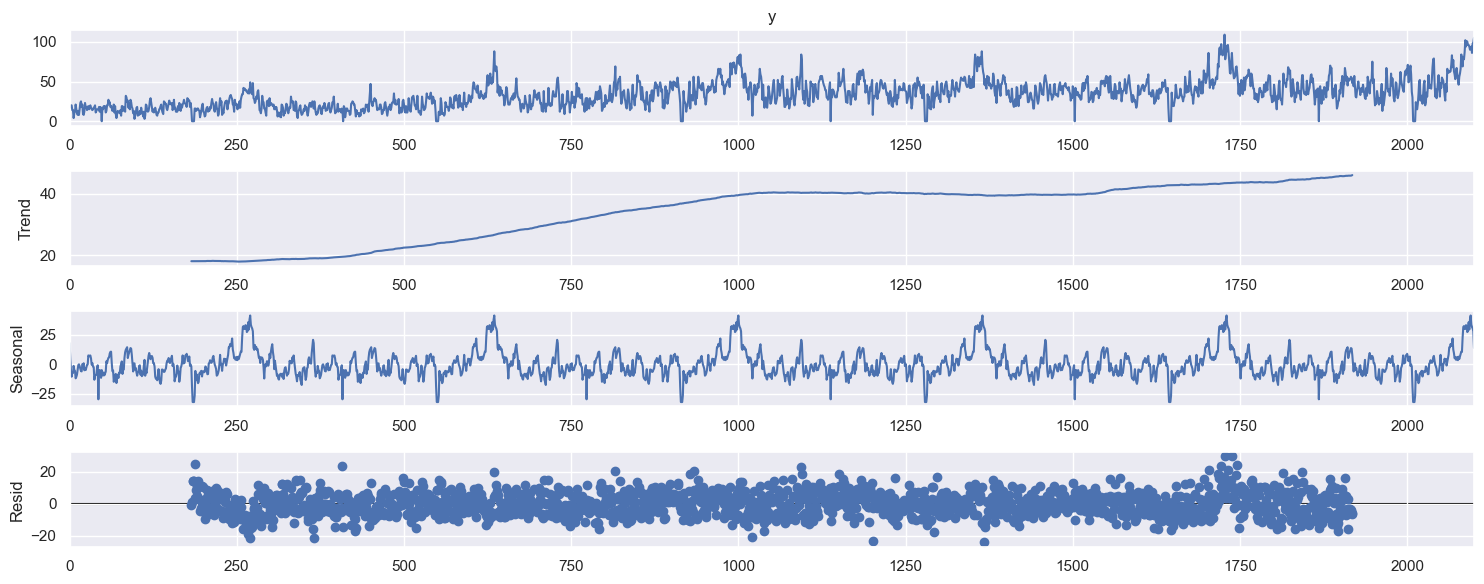

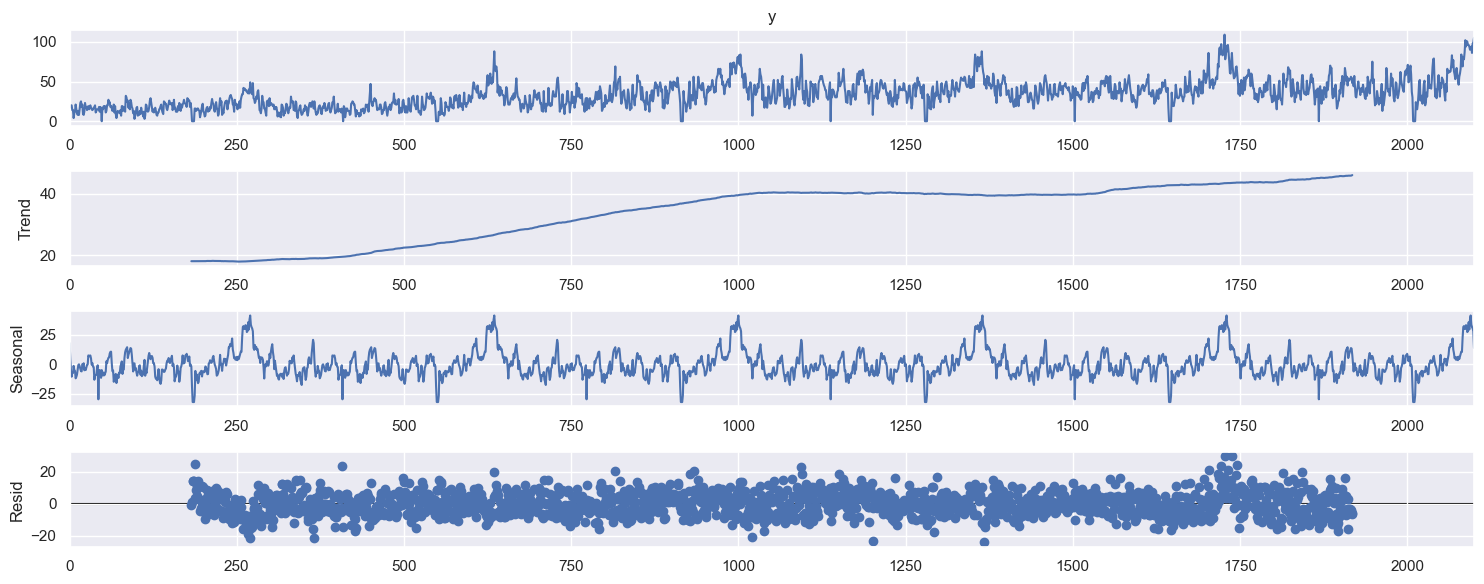

In [55]:
result = seasonal_decompose(data['y'], period=365, two_sided=True)
result.plot()

# ベースラインモデルを作成する

In [57]:
#訓練データと検証データに分割
train_data = data2[data2["datetime"] <="2015-03-31"]
test_data = data2[data2["datetime"] >= "2015-04-01"]

In [59]:
sarima_model = sm.tsa.SARIMAX(train_data['y'], order=(1,1,1), seasonal_order=(1,1,1,365))
result = sarima_model.fit()

result.summary()

c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MemoryError: Unable to allocate 5.85 GiB for an array with shape (733, 733, 1462) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1014, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 5.85 GiB for an array with shape (733, 733, 1462) and data type float64


: 

: 